# Imports
### General imports

In [1]:
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import numpy as np
import pandas as pd

/Users/Sam/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Regressors imports

In [2]:
from sklearn.linear_model import LinearRegression as LM
from sklearn.linear_model import RidgeCV as Ridge
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.neighbors import RadiusNeighborsRegressor as radNN
from sklearn.ensemble import ExtraTreesRegressor as ET
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as Ada
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as ANN

In [69]:
reg = {'LM':LM(),
#      'Ridge':Ridge(),
      'KNN':KNN(),
#      'radNN':radNN(radius=200),
      'DT':DT(random_state=42),
      'RF':RF(random_state=42),
      'ET':ET(n_estimators=100,random_state=42), #random_state=0
#      'Ada':Ada(),
#      'SVM':SVR(),
      'ANN':ANN(max_iter=400,random_state=42) #hidden_layer_sizes=(50,),max_iter=400
      } #shuffle=False,

### Assesment metrics

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

from wikipedia:
There are cases where the computational definition of R2 can yield negative values, depending on the definition used. This can arise when the predictions that are being compared to the corresponding outcomes have not been derived from a model-fitting procedure using those data. Even if a model-fitting procedure has been used, R2 may still be negative, for example when linear regression is conducted without including an intercept,[5] or when a non-linear function is used to fit the data.[6] **In cases where negative values arise, the mean of the data provides a better fit to the outcomes than do the fitted function values, according to this particular criterion**.

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Data Loading

In [54]:
tsla_price = pickle.load(open("../data/data_h_corrected.pickle","rb"))['Open']
tsla_trend = pickle.load(open("../data/GT_tsla_h.pickle","rb"))
musk_trend = pickle.load(open("../data/GT_musk_h.pickle","rb"))
musk_twitter = pickle.load(open("../data/twitter_musk_h.pickle","rb"))
musk_tesla_twitter = pickle.load(open("../data/twitter_musk_tesla_h.pickle","rb"))

In [16]:
print(type(musk_twitter.index))
print(type(musk_tesla_twitter.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [55]:
start_ts = tsla_price.index[0]
end_ts = tsla_price.index[-1]
tsla_trend = tsla_trend[start_ts:end_ts]
musk_trend = musk_trend[start_ts:end_ts]
#musk_twitter = musk_twitter[start_ts:end_ts]
musk_tesla_twitter = musk_tesla_twitter[start_ts:end_ts]
data = pd.concat([tsla_price,tsla_trend,musk_trend,musk_tesla_twitter],axis=1)
#need to replace NAN in the musk_tesla_twitter columns with zero, or the later step of removing NAN rows will delete stuff I don't want
#to delete. This is because I didn't preprocess the musk_tesla_twitter data the same way as the musk_twitter
data[["like_count","retweet_count","reply_count","quote_count"]] = data[["like_count","retweet_count","reply_count","quote_count"]].fillna(0)
#print(data.head(10))

Note to self: there are only 7 hours of prices every working day, whereas there is trend data for every hour of every day... I should keep this in mind, and be wary as it might cause a problem later...

# Cut date for training/test set

In [56]:
cut_date = dt.datetime(year=2021,month=1,day=4,hour=10) # For now just testing various cut point around 2 month
print('cut date = ',cut_date)
#print(pd.Timestamp(cut_date))
#cut_idx = tsla_price.index[tsla_price.index == pd.Timestamp(cut_date)].values[0]
#print('cut index = ',cut_idx)

cut date =  2021-01-04 10:00:00


# Auxilary functions
### Split data

In [11]:
def split_data(data,cut_idx):
    train = data[:cut_idx]
    test = data[cut_idx:]
    return train, test

### Converting from original to log returns and back functions

In [12]:
def convert_to_logret(stock_price):
    initial = stock_price.iloc[0]
    returns = 100*(np.log(stock_price)).diff()
    return returns, initial

def convert_from_logret(returns,initial,axis=0):
    stock_price = np.exp((returns/100).cumsum(axis)) * initial
    return stock_price

### Plot Prediction function

In [13]:
def plot_predict(stock_train,stock_test,stock_predict):
    fig, axs =plt.subplots(1,2,figsize=(20,5))

    axs[0].plot(stock_train)
    axs[0].plot(stock_test)
    axs[0].plot(stock_predict)

    axs[1].plot(stock_train[-300:])
    axs[1].plot(stock_test)
    axs[1].plot(stock_predict)
    return


#y_test_true = response[cut_idx:-35*4]
#x_test = features[cut_idx:-35*4]
#y_test = dectree_v2.predict(x_test)

#y_train_os = np.exp((response[:cut_idx]/100).cumsum()+np.log(tsla['Open'].iloc[0]))
#offset = ((response[:cut_idx]/100).cumsum()+np.log(tsla['Open'].iloc[0])).iloc[-1,0]
#print(np.exp(offset))
#y_test_os = np.exp((y_test/100).cumsum(1)+offset)
#y_test_true_os = np.exp((y_test_true/100).cumsum(1)+offset)



# Features and responses

In [57]:
time = pd.Series(data=range(len(tsla_trend)),index=tsla_trend.index)
data['time'] = time
returns, initial = convert_to_logret(tsla_price)
data['returns'] = returns
#print(data.head(20))
data.dropna(inplace=True)
#print(data.head(20))

# price shifting

In [37]:
def shift(df,column,list_shifts):
    for i in list_shifts:
        name = column + str(-i)
        df[name]=df[column].shift(i)
    return df

In [73]:
data = shift(data,'returns',range(-35*4+1,35*4+1))
data = shift(data,'tsla',range(1,35*4+1))
data = shift(data,'musk',range(1,35*4+1))
data = shift(data,'like_count',range(1,35*4+1))
data = shift(data,'retweet_count',range(1,35*4+1))
data = data.dropna()

In [26]:
print(data.head())

                          Open   tsla  musk  like_count  retweet_count  \
2019-03-12 11:00:00  56.785999    8.4   2.8         0.0            0.0   
2019-03-12 12:00:00  56.437542  11.04   2.8         0.0            0.0   
2019-03-12 13:00:00  56.417999  14.16  3.12         0.0            0.0   
2019-03-12 14:00:00  56.757141   15.6  3.04         0.0            0.0   
2019-03-12 15:00:00  56.629997   15.6  3.12         0.0            0.0   

                     reply_count  quote_count  time   returns  returns139  \
2019-03-12 11:00:00          0.0          0.0   701 -0.831247   -0.992845   
2019-03-12 12:00:00          0.0          0.0   702 -0.615523    0.875030   
2019-03-12 13:00:00          0.0          0.0   703 -0.034633   -0.489179   
2019-03-12 14:00:00          0.0          0.0   704  0.599324    0.515817   
2019-03-12 15:00:00          0.0          0.0   705 -0.224265   -0.383862   

                     ...  retweet_count-131  retweet_count-132  \
2019-03-12 11:00:00  ...  

In [58]:
f_list = ['tsla','musk','time','retweet_count','like_count'] #'tsla','musk','time','retweet_count','like_count'
#f_list2 = f_list + ['returns'+str(i) for i in range(-35*4,0)]
features = data[f_list]
#features2 = data[f_list2]
response = data[['returns']]
#response2 = data[['returns']+['returns'+str(i) for i in range(1,35*4)]]
#print(features2)
#print(response2)

# training

In [59]:
#cut_idx = tsla_price.reset_index().index[tsla_price.index == pd.Timestamp(cut_date)].values[0]
cut_idx = pd.Timestamp(cut_date)
#print('cut index = ',cut_idx)

x_train, x_test = split_data(features,cut_idx)
y_train, y_test = split_data(response,cut_idx)
#x2_train, x2_test = split_data(features2,cut_idx)
#y2_train, y2_test = split_data(response2,cut_idx)
#x2_train = x2_train[:-35*4]
#y2_train = y2_train[:-35*4]

#print(x_train)
#print(x_test)
#print(y_train)
#print(y_test)

In [60]:
#Scaler
scaler = MinMaxScaler()
x_train_minmax = scaler.fit_transform(x_train,y_train)

metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2","MSE_original_scale","R2_original_scale"])

# fitting the models

In [70]:
#reg['LM'].fit(x_train,y_train)
for model in reg:
    reg[model].fit(x_train_minmax,y_train['returns'])

# Prediction

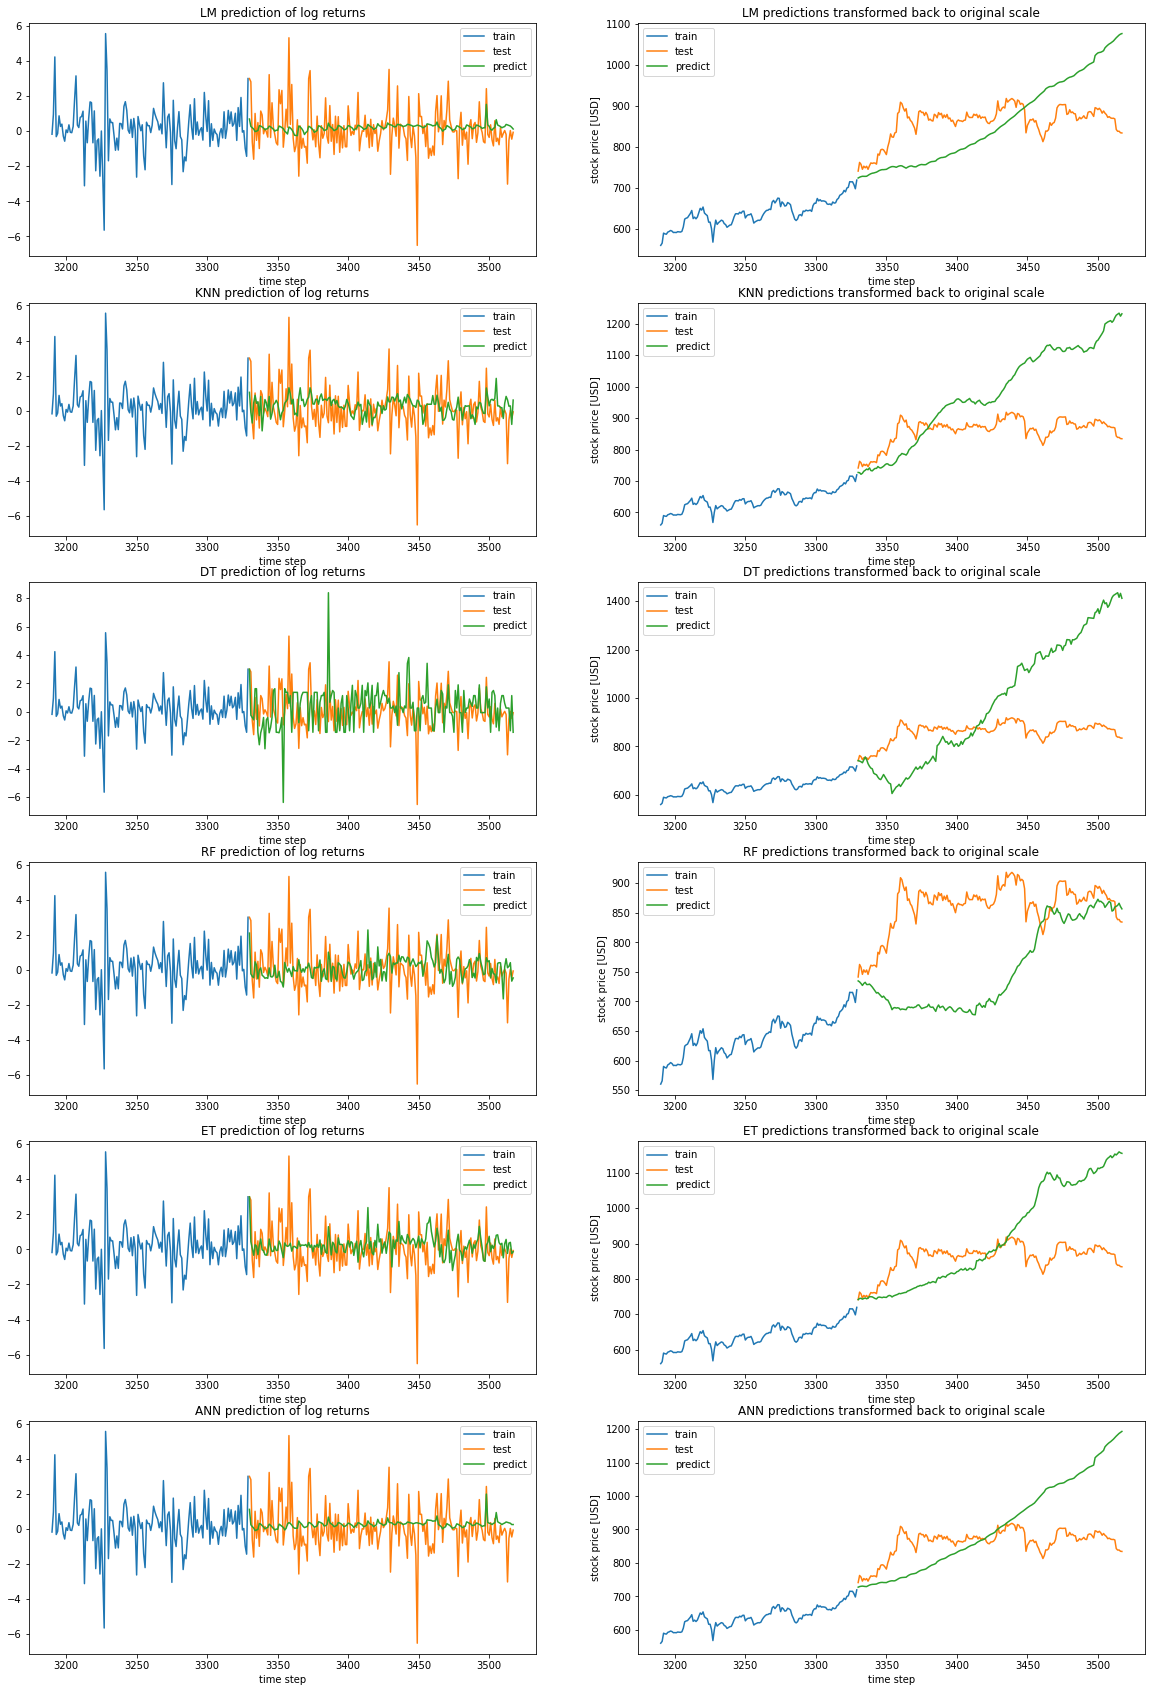

In [71]:
fig, axs =plt.subplots(len(reg),2,figsize=(20,5*len(reg)))
i = 0

for model in reg:
    #print(model)
    y_predict = reg[model].predict(scaler.transform(x_test))
    y_predict = pd.DataFrame(y_predict, index=x_test.index)
    y_train_os = convert_from_logret(y_train,initial,axis=0)
    y_test_os = convert_from_logret(y_test,data.loc[cut_idx,'Open'],axis=0)
    y_predict_os = convert_from_logret(y_predict,data['Open'][cut_idx],axis=0)
    #plot_predict(y_train,y_test,y_predict)
    #plot_predict(y_train_os,y_test_os,y_predict_os)
    
    n_train = len(y_train)
    n_test = len(y_test_os)
    
    axs[i,0].plot(range(n_train-35*4,n_train),y_train.iloc[-35*4:])
    axs[i,0].plot(range(n_train,n_train+n_test),y_test)
    axs[i,0].plot(range(n_train,n_train+n_test),y_predict[0])
    
    axs[i,0].legend(['train','test','predict'])
    axs[i,0].set_title(model + ' prediction of log returns')
    axs[i,0].set_xlabel("time step")

    axs[i,1].plot(range(n_train-35*4,n_train),y_train_os.iloc[-35*4:])
    axs[i,1].plot(range(n_train,n_train+n_test),y_test_os)
    axs[i,1].plot(range(n_train,n_train+n_test),y_predict_os[0])

    axs[i,1].legend(['train','test','predict'])
    axs[i,1].set_title(model + ' predictions transformed back to original scale')
    axs[i,1].set_xlabel("time step")
    axs[i,1].set_ylabel("stock price [USD]")
    
    
    
    metrics["MSE"][model] = mean_squared_error(y_test, y_predict)
    metrics["R2"][model] = r2_score(y_test,y_predict)
    metrics["MSE_original_scale"][model] = mean_squared_error(y_test_os, y_predict_os)
    metrics["R2_original_scale"][model] = r2_score(y_test_os,y_predict_os)
    
    i=i+1

img_mlresults_basic = "../report/img/img_mlresults_basic.pdf"
plt.savefig(img_mlresults_basic,bbox_inches="tight")
plt.show()

# Assesment

In [27]:
#from pandas.plotting import table 

In [72]:
#print("mean square error : ",mean_squared_error(y_test, y_predict))
#print("R2 : ",r2_score(y_test,y_predict))

print(metrics)
#ax = plt.subplot(111, frame_on=False)
#ax.xaxis.set_visible(False)  # hide the x axis
#ax.yaxis.set_visible(False)  # hide the y axis

#table(ax,metrics)
#tab_mlresults_basic = "../report/img/tab_mlresults_basic.pdf"
#plt.savefig(tab_mlresults_basic,bbox_inches="tight")
tab_mlresults_basic = "../report/tab/tab_mlresults_basic.tex"

metrics.to_latex(tab_mlresults_basic,caption="Error measures of the univariate response case, on the log returns scale and original scale",label="tab:mlresults_basic")

          MSE        R2 MSE_original_scale R2_original_scale
LM   1.650403  0.008168        9606.311211           -4.8631
KNN  1.808194 -0.086659       31215.174459        -18.051819
DT   3.679189  -1.21106       72790.038001        -43.426554
RF   1.918753 -0.153101       17207.088123         -9.502146
ET   1.878936 -0.129173       20718.301652        -11.645175
ANN  1.671615  -0.00458        18571.14794        -10.334684


# Part 2

In [47]:
#reg['KNN'].fit(x2_train,y2_train)
for model in reg:
    reg[model].fit(x2_train,y2_train)

LM


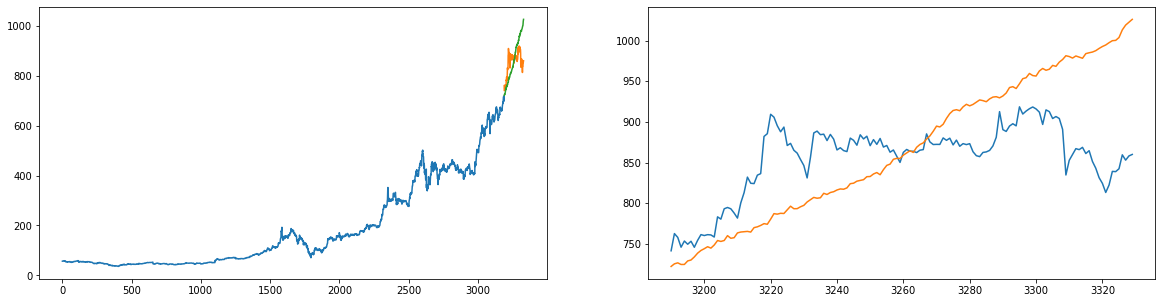

Ridge


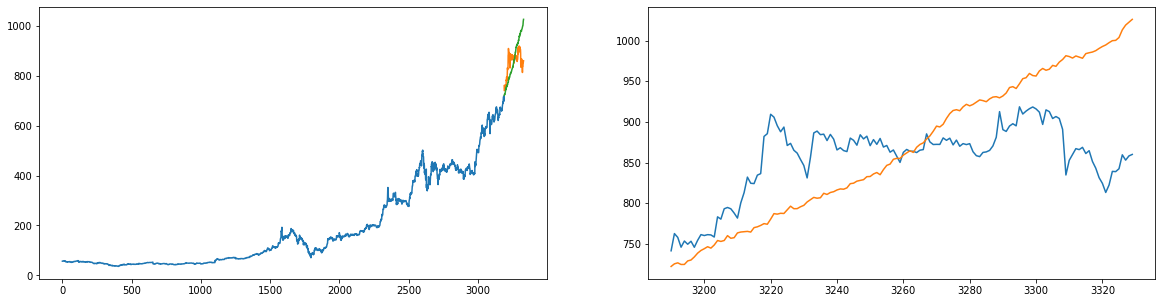

KNN


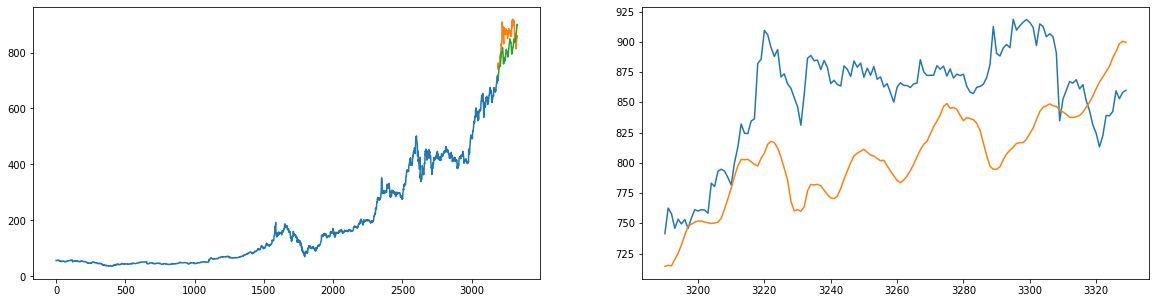

DT


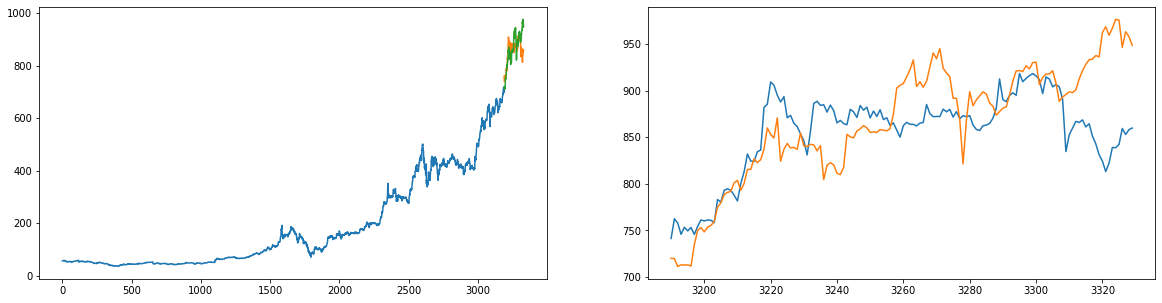

ET


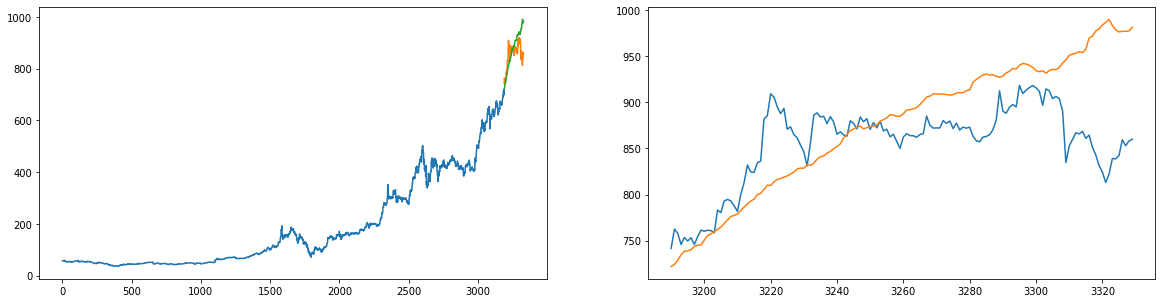

ANN


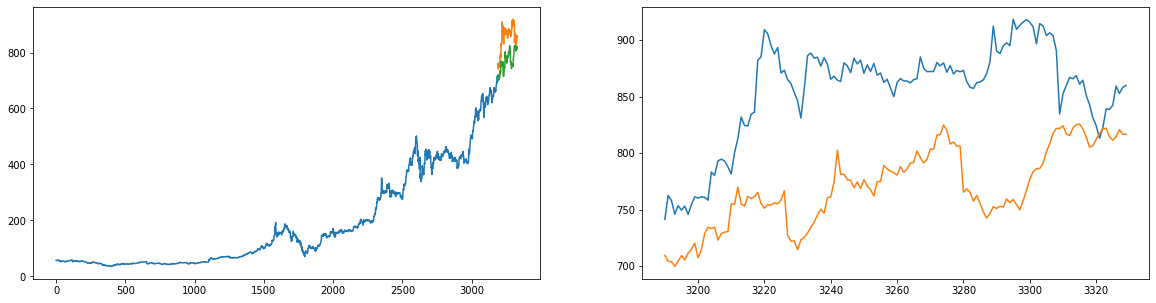

            MSE        R2 MSE_original_scale R2_original_scale
LM      1.97216 -0.041563        5611.508592          -1.87074
Ridge   1.97195 -0.041451        5610.691186         -1.870322
KNN    2.091144 -0.104402        4031.657174         -1.062518
DT     4.175372 -1.205151        2365.611784         -0.210202
ET     2.003438 -0.058082         3507.24044         -0.794237
ANN    3.352576 -0.770605        8950.910832         -3.579114


In [177]:
metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2","MSE_original_scale","R2_original_scale"])
for model in reg: ####### reg
    print(model)
    y2_predict = reg[model].predict(x2_test)
    y2_predict = pd.DataFrame(y2_predict, index=x2_test.index)
    
    iidx = pd.Timestamp(pd.to_datetime(y2_train.index[0])+dt.timedelta(hours=-1))
    #print(iidx)
    initial = tsla_price.iloc[tsla_price.index.get_loc(iidx,method="pad")]
    #print(initial)
    
    y2_train_os = convert_from_logret(y2_train,initial)
    y2_test_os = convert_from_logret(y2_test,data['Open'][cut_idx],axis=1)
    y2_predict_os = convert_from_logret(y2_predict,data['Open'][cut_idx],axis=1)
    #plot_predict(y_train,y_test,y_predict)
    #plot_predict(y_train_os,y_test_os.iloc[0],y_predict_os.iloc[0])
    #print(x2_train)
    #plt.show()
    
    
    fig, axs =plt.subplots(1,2,figsize=(20,5))

    #n_train = len(y2_train_os['returns'])
    n_train = len(data['Open'][:cut_idx])
    n_test = len(y2_test_os.iloc[0])

    axs[0].plot(range(n_train),data['Open'][:cut_idx])
    axs[0].plot(range(n_train,n_train+n_test),y2_test_os.iloc[0])
    axs[0].plot(range(n_train,n_train+n_test),y2_predict_os.iloc[0])
    #axs[0].plot(range(3050+140-92),tsla_price.iloc[140:-140])



    #axs[1].plot(range(n_train-300,n_train),data['Open'][:cut_idx][-300:])
    axs[1].plot(range(n_train,n_train+n_test),y2_test_os.iloc[0])
    axs[1].plot(range(n_train,n_train+n_test),y2_predict_os.iloc[0])
    #axs[1].plot(range(2750+140-92,3050+280-92),tsla_price.iloc[-440:])

    plt.show()
    
    metrics["MSE"][model] = mean_squared_error(y2_test.iloc[0], y2_predict.iloc[0])
    metrics["R2"][model] = r2_score(y2_test.iloc[0],y2_predict.iloc[0])
    metrics["MSE_original_scale"][model] = mean_squared_error(y2_test_os.iloc[0],y2_predict_os.iloc[0])
    metrics["R2_original_scale"][model] = r2_score(y2_test_os.iloc[0],y2_predict_os.iloc[0])

print(metrics)
    
    

# Using one month to predict one week ahead

In [178]:
x3_train = x2_train[:-35]
y3_train = y2_train[['returns']+['returns'+str(i) for i in range(1,35)]][:-35]

In [40]:
#print(x2_train.head())
#print(y3_train.head())

In [179]:
for model in reg:
    reg[model].fit(x3_train,y3_train)

LM


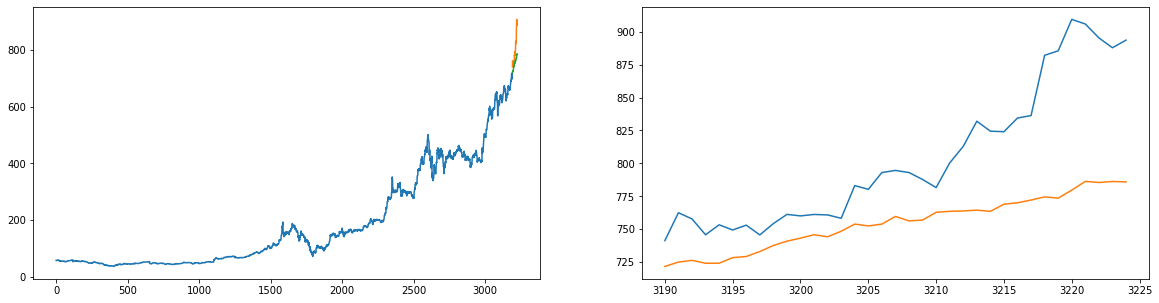

Ridge


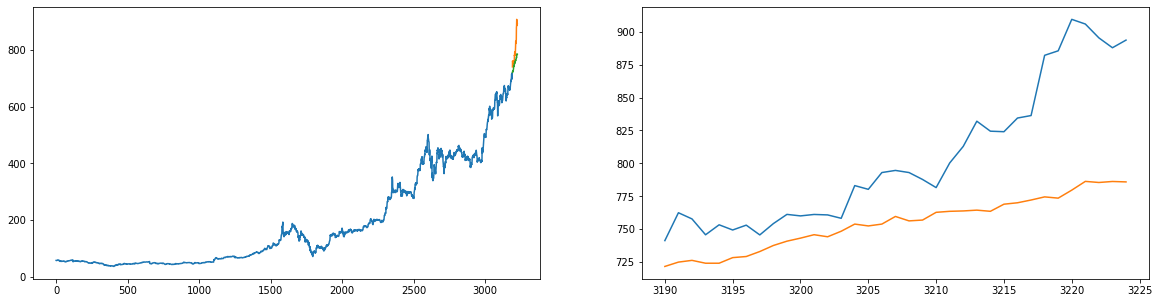

KNN


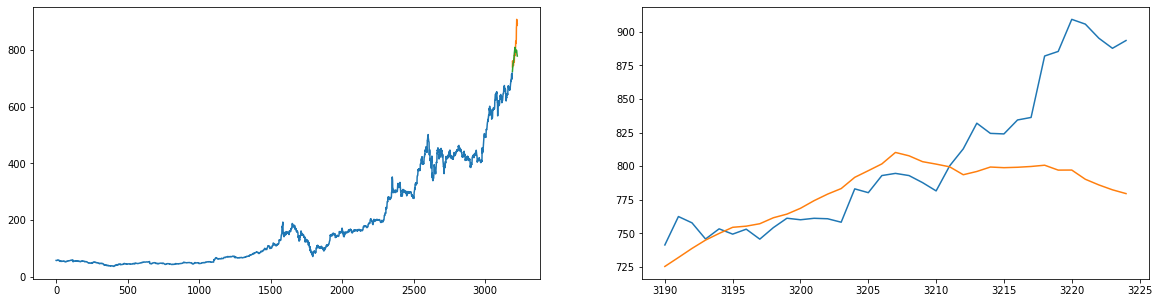

DT


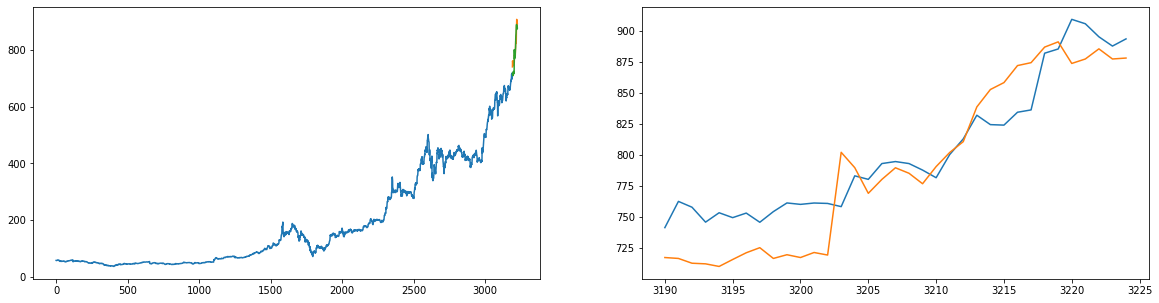

ET


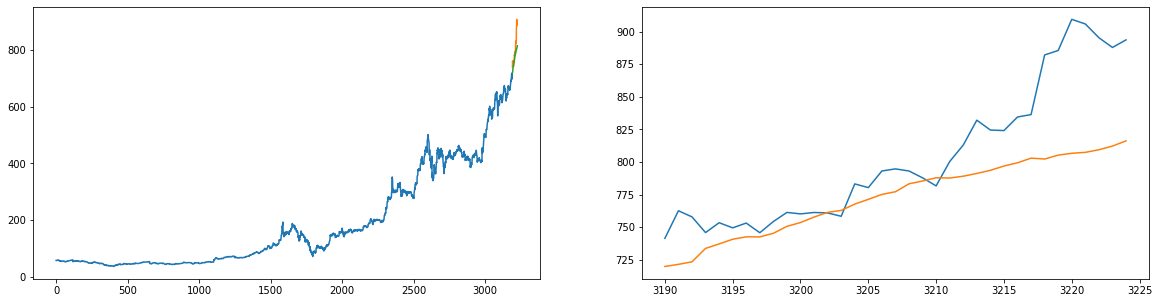

ANN


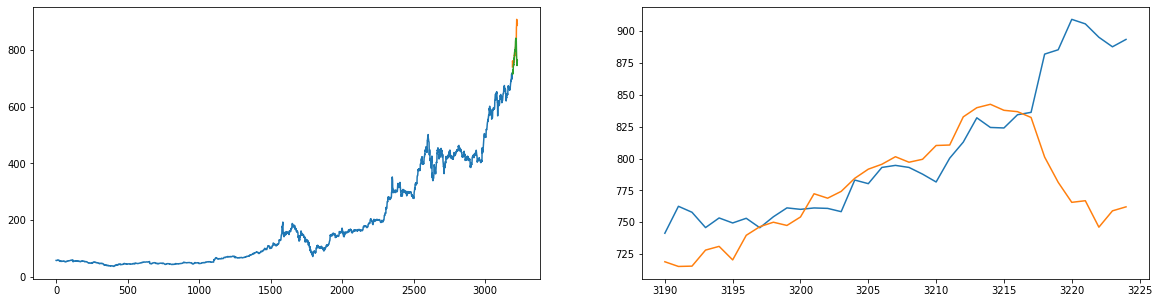

            MSE        R2 MSE_original_scale R2_original_scale
LM     2.312941 -0.016064        3608.585651         -0.288872
Ridge  2.312922 -0.016056        3607.995406         -0.288661
KNN    2.465033 -0.082877        2468.557369           0.11831
DT     7.074975 -2.108004          819.37731          0.707344
ET      2.70363 -0.187692        1826.789094          0.347529
ANN     5.70461 -1.506008        3508.431446           -0.2531


In [180]:
metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2","MSE_original_scale","R2_original_scale"])
for model in reg: ####### reg
    print(model)
    y3_predict = reg[model].predict(x2_test)
    y3_predict = pd.DataFrame(y3_predict, index=x2_test.index)
    
    iidx = pd.Timestamp(pd.to_datetime(y3_train.index[0])+dt.timedelta(hours=-1))
    #print(iidx)
    initial = tsla_price.iloc[tsla_price.index.get_loc(iidx,method="pad")]
    #print(initial)
    
    y3_test = y2_test[['returns']+['returns'+str(i) for i in range(1,35)]]
    
    y3_train_os = convert_from_logret(y3_train,initial)
    y3_test_os = convert_from_logret(y3_test,data['Open'][cut_idx],axis=1)
    y3_predict_os = convert_from_logret(y3_predict,data['Open'][cut_idx],axis=1)
    #plot_predict(y_train,y_test,y_predict)
    #plot_predict(y_train_os,y_test_os.iloc[0],y_predict_os.iloc[0])
    #print(x2_train)
    #plt.show()
    
    
    fig, axs =plt.subplots(1,2,figsize=(20,5))

    #n_train = len(y2_train_os['returns'])
    n_train = len(data['Open'][:cut_idx])
    n_test = len(y3_test_os.iloc[0])

    axs[0].plot(range(n_train),data['Open'][:cut_idx])
    axs[0].plot(range(n_train,n_train+n_test),y3_test_os.iloc[0])
    axs[0].plot(range(n_train,n_train+n_test),y3_predict_os.iloc[0])
    #axs[0].plot(range(3050+140-92),tsla_price.iloc[140:-140])



    #axs[1].plot(range(n_train-300,n_train),data['Open'][:cut_idx][-300:])
    axs[1].plot(range(n_train,n_train+n_test),y3_test_os.iloc[0])
    axs[1].plot(range(n_train,n_train+n_test),y3_predict_os.iloc[0])
    #axs[1].plot(range(2750+140-92,3050+280-92),tsla_price.iloc[-440:])

    plt.show()
    
    metrics["MSE"][model] = mean_squared_error(y3_test.iloc[0], y3_predict.iloc[0])
    metrics["R2"][model] = r2_score(y3_test.iloc[0],y3_predict.iloc[0])
    metrics["MSE_original_scale"][model] = mean_squared_error(y3_test_os.iloc[0],y3_predict_os.iloc[0])
    metrics["R2_original_scale"][model] = r2_score(y3_test_os.iloc[0],y3_predict_os.iloc[0])

print(metrics)

# making the code more robust

In [74]:
forward_timesteps = 35 #one week
backward_timesteps = -35*4 #four weeks

stock_variables = ["returns"]+['returns'+str(i) for i in range(backward_timesteps,0)]
g_trend_variables = ["tsla","musk"]+['tsla'+str(i) for i in range(backward_timesteps,0)]#+['musk'+str(i) for i in range(backward_timesteps,0)]
twitter_variables = [] + ["retweet_count"]+['retweet_count'+str(i) for i in range(backward_timesteps,0)]#+ ["like_count"]+['like_count'+str(i) for i in range(backward_timesteps,0)]

feature_list = stock_variables + g_trend_variables + twitter_variables + ["time"]
response_list = ["returns"]+['returns'+str(i) for i in range(1,forward_timesteps)]

features = data[feature_list]
responses = data[response_list]

cut_idx = pd.Timestamp(cut_date)

x_train, x_test = split_data(features,cut_idx)
y_train, y_test = split_data(responses,cut_idx)

#correction for overlapping features and responses:
x_train = x_train[:-forward_timesteps]
y_train = y_train[:-forward_timesteps]
    
#Scaler
scaler = MinMaxScaler()
x_train_minmax = scaler.fit_transform(x_train,y_train)
    
metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2","MSE_original_scale","R2_original_scale"])

In [75]:
for model in reg:
    reg[model].fit(x_train_minmax,y_train)

/Users/Sam/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


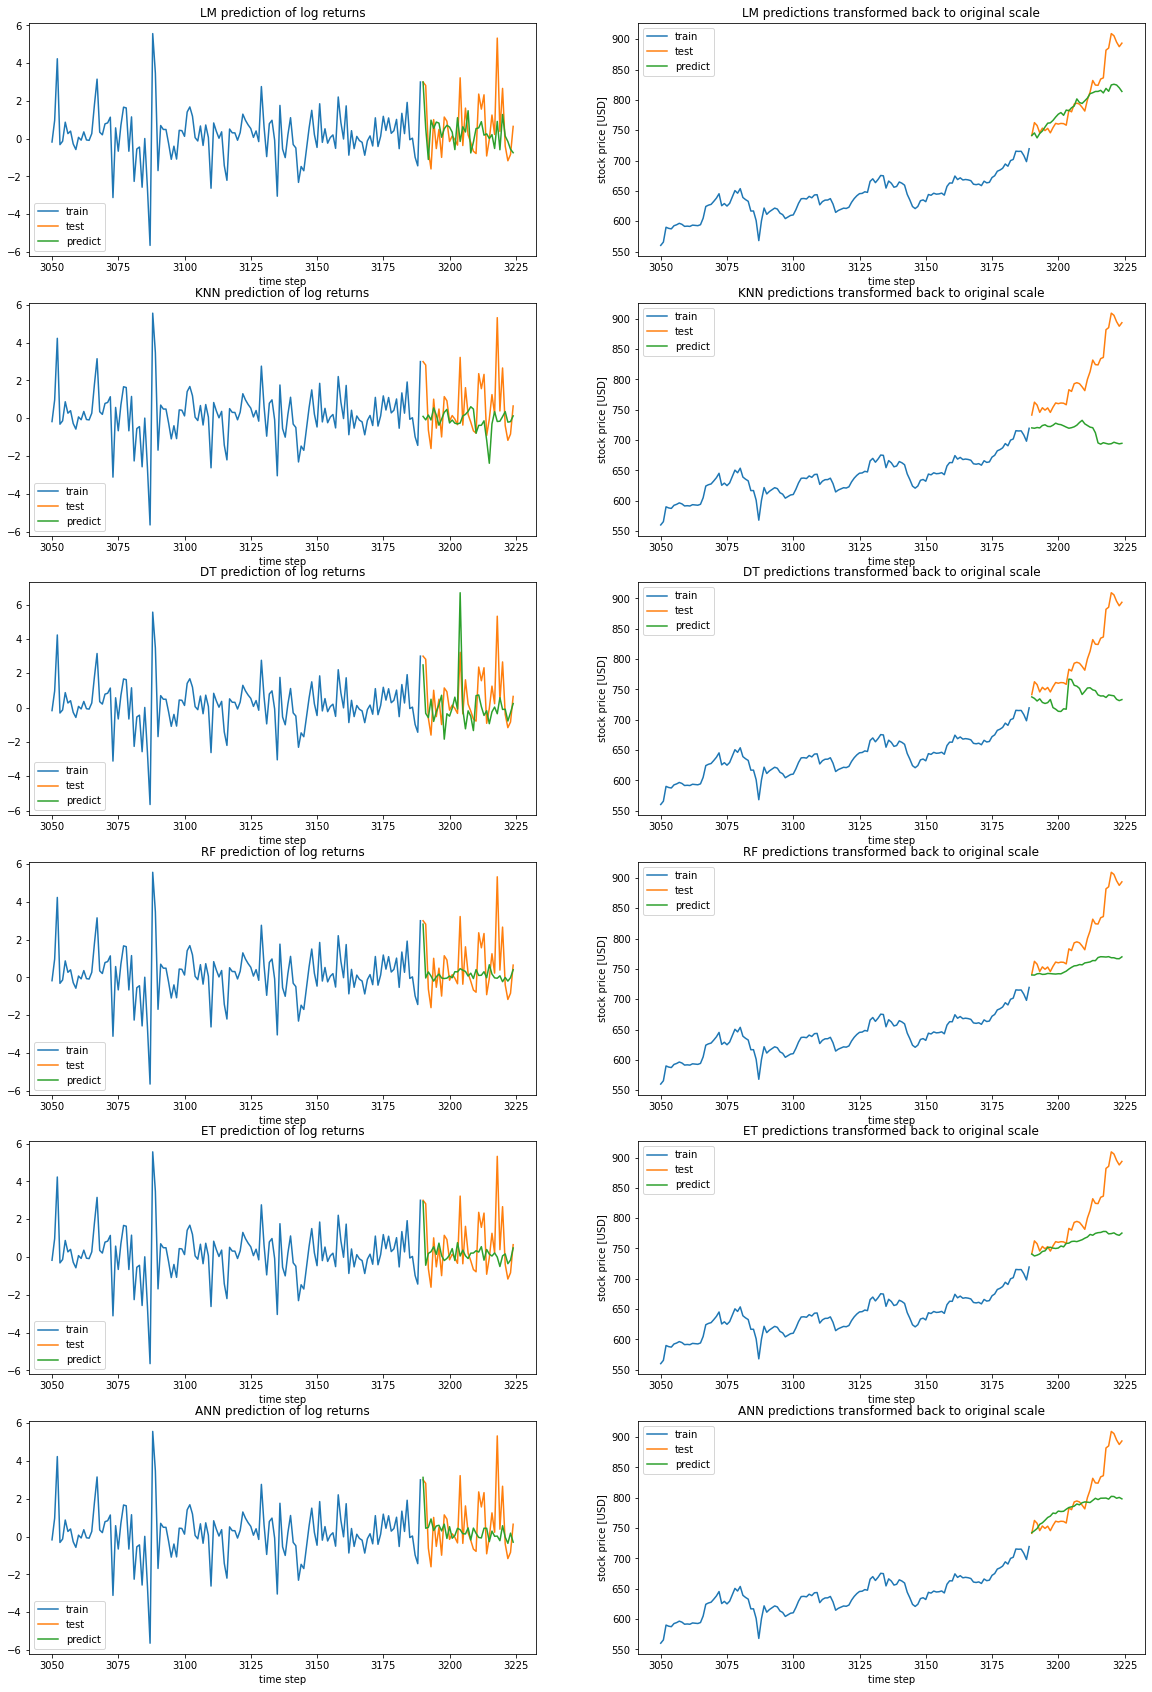

In [78]:
fig, axs =plt.subplots(len(reg),2,figsize=(20,5*len(reg)))
i = 0

for model in reg:
    y_predict = reg[model].predict(scaler.transform(x_test))
    y_predict = pd.DataFrame(y_predict, index=x_test.index)
    
    #we need the initial stock price to transforme the returns back into the real price
    iidx = pd.Timestamp(pd.to_datetime(y_train.index[0])+dt.timedelta(hours=-1))
    initial = tsla_price.iloc[tsla_price.index.get_loc(iidx,method="pad")]
    
    #change the returns back to the price (os=original scale)
    y_train_os = convert_from_logret(y_train,initial)
    y_test_os = convert_from_logret(y_test,data['Open'][cut_idx],axis=1)
    y_predict_os = convert_from_logret(y_predict,data['Open'][cut_idx],axis=1)
    
    
    
    #n_train = len(y2_train_os['returns'])
    n_train = len(data['Open'][:cut_idx])
    n_test = len(y_test_os.iloc[0])
    #print(n_train, n_test, backward_timesteps)

    axs[i,0].plot(range(n_train+backward_timesteps,n_train),data['returns'][:cut_idx][backward_timesteps:])
    axs[i,0].plot(range(n_train,n_train+n_test),y_test.iloc[0])
    axs[i,0].plot(range(n_train,n_train+n_test),y_predict.iloc[0])
    
    axs[i,0].legend(['train','test','predict'])
    axs[i,0].set_title(model + ' prediction of log returns')
    axs[i,0].set_xlabel("time step")

    axs[i,1].plot(range(n_train+backward_timesteps,n_train),data['Open'][:cut_idx][backward_timesteps:])
    axs[i,1].plot(range(n_train,n_train+n_test),y_test_os.iloc[0])
    axs[i,1].plot(range(n_train,n_train+n_test),y_predict_os.iloc[0])

    axs[i,1].legend(['train','test','predict'])
    axs[i,1].set_title(model + ' predictions transformed back to original scale')
    axs[i,1].set_xlabel("time step")
    axs[i,1].set_ylabel("stock price [USD]")
    
    
    metrics["MSE"][model] = mean_squared_error(y_test.iloc[0], y_predict.iloc[0])
    metrics["R2"][model] = r2_score(y_test.iloc[0],y_predict.iloc[0])
    metrics["MSE_original_scale"][model] = mean_squared_error(y_test_os.iloc[0],y_predict_os.iloc[0])
    metrics["R2_original_scale"][model] = r2_score(y_test_os.iloc[0],y_predict_os.iloc[0])
    
    i=i+1

img_mlresults_v2 = "../report/img/img_mlresults_v2.pdf"
plt.savefig(img_mlresults_v2,bbox_inches="tight")
plt.show()


In [79]:
print(metrics)

tab_mlresults_v2 = "../report/tab/tab_mlresults_v2.tex"

metrics.to_latex(tab_mlresults_v2,caption="Error measures of the multivariate response case, on the log returns scale and original scale",label="tab:mlresults_v2")

          MSE        R2 MSE_original_scale R2_original_scale
LM   2.102195  0.076515        1238.834902          0.557528
KNN  2.970451 -0.304905       11916.125384         -3.256061
DT   3.208266 -0.409377         6911.49391         -1.468566
RF   2.352084 -0.033259        4159.203129         -0.485535
ET   2.525555 -0.109464        3558.157331         -0.270861
ANN  2.352469 -0.033429        2063.433091          0.263007


# -------------------------------------------------------------------------

In [23]:
model='ANN'
reg[model].fit(x_train,y_train)
y_predict_temp = reg[model].predict(x_test)
y_predict = pd.DataFrame(1/50*y_predict_temp, index=x_test.index)

for i in range(50):
    reg['ANN'].fit(x_train,y_train)
    y_predict_temp = reg[model].predict(x_test)
    y_predict = y_predict.add(pd.DataFrame(1/50*y_predict_temp, index=x_test.index))

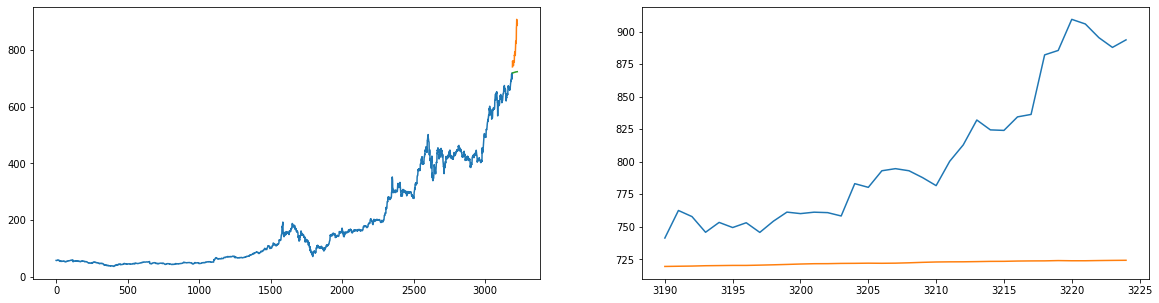

          MSE        R2 MSE_original_scale R2_original_scale
LM   2.102195  0.076515        1238.834902          0.557528
KNN  2.694193 -0.183546       11733.935778         -3.190989
DT   2.931739 -0.287899        8681.904986         -2.100901
ET   2.432195 -0.068452        2285.391069          0.183731
ANN  2.656539 -0.167005        9180.910453         -2.279129


In [24]:
#we need the initial stock price to transforme the returns back into the real price
iidx = pd.Timestamp(pd.to_datetime(y_train.index[0])+dt.timedelta(hours=-1))
initial = tsla_price.iloc[tsla_price.index.get_loc(iidx,method="pad")]
    
#change the returns back to the price (os=original scale)
y_train_os = convert_from_logret(y_train,initial)
y_test_os = convert_from_logret(y_test,data['Open'][cut_idx],axis=1)
y_predict_os = convert_from_logret(y_predict,data['Open'][cut_idx],axis=1)
    
fig, axs =plt.subplots(1,2,figsize=(20,5))

#n_train = len(y2_train_os['returns'])
n_train = len(data['Open'][:cut_idx])
n_test = len(y_test_os.iloc[0])

axs[0].plot(range(n_train),data['Open'][:cut_idx])
axs[0].plot(range(n_train,n_train+n_test),y_test_os.iloc[0])
axs[0].plot(range(n_train,n_train+n_test),y_predict_os.iloc[0])

#axs[1].plot(range(n_train-backward_timesteps,n_train),data['Open'][:cut_idx][-backward_timesteps:])
axs[1].plot(range(n_train,n_train+n_test),y_test_os.iloc[0])
axs[1].plot(range(n_train,n_train+n_test),y_predict_os.iloc[0])

plt.show()
    
metrics["MSE"][model] = mean_squared_error(y_test.iloc[0], y_predict.iloc[0])
metrics["R2"][model] = r2_score(y_test.iloc[0],y_predict.iloc[0])
metrics["MSE_original_scale"][model] = mean_squared_error(y_test_os.iloc[0],y_predict_os.iloc[0])
metrics["R2_original_scale"][model] = r2_score(y_test_os.iloc[0],y_predict_os.iloc[0])
    
print(metrics)